In [2]:
!pip install ultralytics opencv-contrib-python segment-anything cvlib

In [3]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

In [4]:
from google.colab import files
uploaded = files.upload()

Saving puppy-5124947_640.jpg to puppy-5124947_640.jpg


In [5]:

!wget https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
!wget https://pjreddie.com/media/files/yolov3.weights


--2024-09-25 22:01:37--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg [following]
--2024-09-25 22:01:38--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-09-25 22:01:38 (54.3 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2024-09-25 22:01:38--  https://pjreddie.com/media/files/yolov3.weights


In [6]:
import cv2
import numpy as np

# Load the YOLO model
weights = "/content/yolov3.weights"
config = "/content/yolov3.cfg"
net = cv2.dnn.readNet(weights, config)

# Load the image
img = cv2.imread("/content/puppy-5124947_640.jpg")

# Prepare the image for the model
height, width, _ = img.shape
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

# Get the output layer names and perform a forward pass
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
outs = net.forward(output_layers)

# Initialize lists to hold detection data
class_ids = []
confidences = []
boxes = []

# Loop through each output layer
for out in outs:
    for detection in out:
        scores = detection[5:]  # The class scores start from index 5
        class_id = np.argmax(scores)  # Get the class with the highest score
        confidence = scores[class_id]  # Get the confidence of that class

        # Filter out weak detections
        if confidence > 0.3:  # You can adjust the threshold here
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Get the bounding box coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-maxima suppression to suppress overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3,0.4)

# Load the COCO class labels
with open("/content/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Draw bounding boxes on the image
def draw_bbox(img, boxes, class_ids, confidences, indices):
    for i in indices:
        if isinstance(i, np.ndarray):
            i = i[0]  # Get the index if it's an array
        box = boxes[i]
        (x, y, w, h) = box
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return img

# Call the function to draw bounding boxes
output_image = draw_bbox(img, boxes, class_ids, confidences, indices)

# Save the output image
cv2.imwrite("output.jpg", output_image)

True

In [7]:
print(h)

235


In [8]:
import torch
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
import numpy as np



# Load the SAM model (you can choose different versions, e.g., vit_b, vit_l, vit_h)
model_type = "vit_h"
sam_checkpoint = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Initialize the predictor
predictor = SamPredictor(sam)



/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [9]:
# Load your image
image_path = "/content/puppy-5124947_640.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set the image for SAM
predictor.set_image(image_rgb)


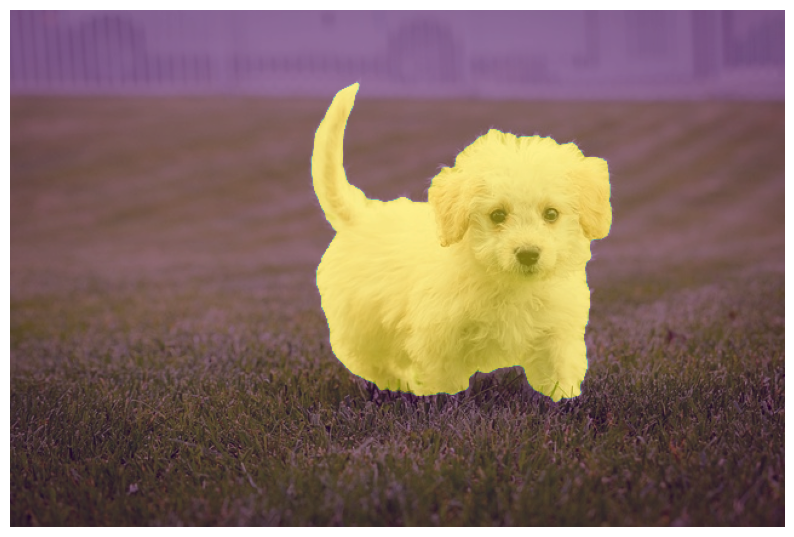

In [10]:

# Define a bounding box around the object of interest (x0, y0, x1, y1)
# Example coordinates: replace with your box coordinates
padding = 50
input_box = np.array([x-padding,y-padding,x+w+padding,y+h+padding])  # You need to define these values yourself

# Convert the bounding box to a tensor
input_box = torch.tensor(input_box).unsqueeze(0).numpy() # Add batch dimension

# Get the segmentation result using the bounding box
masks, _, _ = predictor.predict(box=input_box)

# Display the segmentation mask on the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)

# Overlay the mask
for mask in masks:
    plt.imshow(mask, alpha=0.2)  # You can adjust alpha for transparency

plt.axis('off')
plt.show()

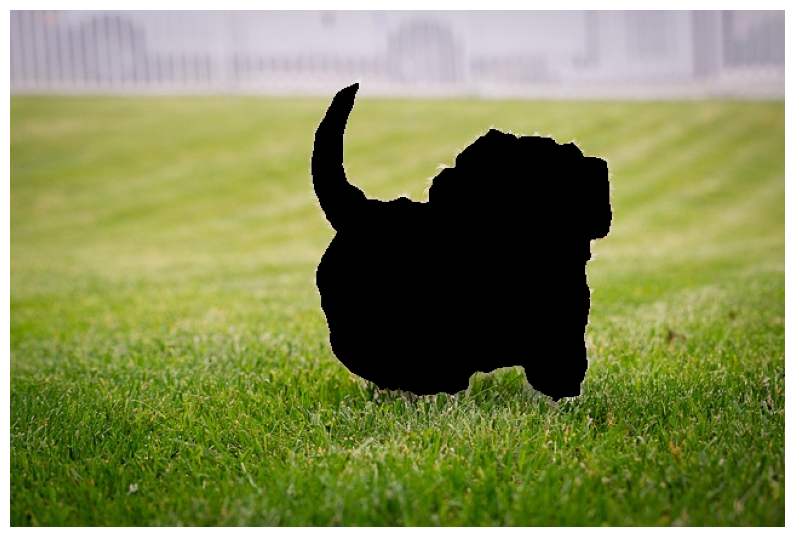

True

In [11]:
mask = masks[0]  # Assuming we take the first mask if multiple masks exist


# Convert mask to 3-channel if your image is in RGB (shape: [H, W, 3])
mask_3_channel = np.stack([mask]*3, axis=-1)  # Convert to 3-channel for RGB

# Set the object area (where mask is True) to black
image_with_black = np.where(mask_3_channel, [0, 0, 0], image_rgb)

# Display the modified image
plt.figure(figsize=(10, 10))
plt.imshow(image_with_black)
plt.axis('off')
plt.show()

# Convert the result image to uint8 (ensure values are in the range [0, 255])
image_with_black_uint8 = image_with_black.astype(np.uint8)

# Save the modified image
cv2.imwrite("modified_image.jpg", cv2.cvtColor(image_with_black_uint8, cv2.COLOR_RGB2BGR))

In [12]:
!pip install diffusers transformers accelerate
!pip install torch torchvision
!pip install opencv-python-headless

In [13]:
# Cell 2: Import Libraries
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import numpy as np
import cv2

In [14]:
# Cell 3: Load Stable Diffusion Inpainting model (TPU-optimized)
# Ensure you're using float32 dtype for TPU
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float32
).to("cpu")  # TPU mode runs on CPU for diffusers

# You can enable TPU using the accelerator library if needed in a separate TPU cell.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_

In [15]:
# Cell 4: Helper functions for image conversion
# Convert OpenCV images (BGR) to PIL format
def cv2_to_pil(img):
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Convert PIL image to OpenCV (BGR format)
def pil_to_cv2(pil_img):
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

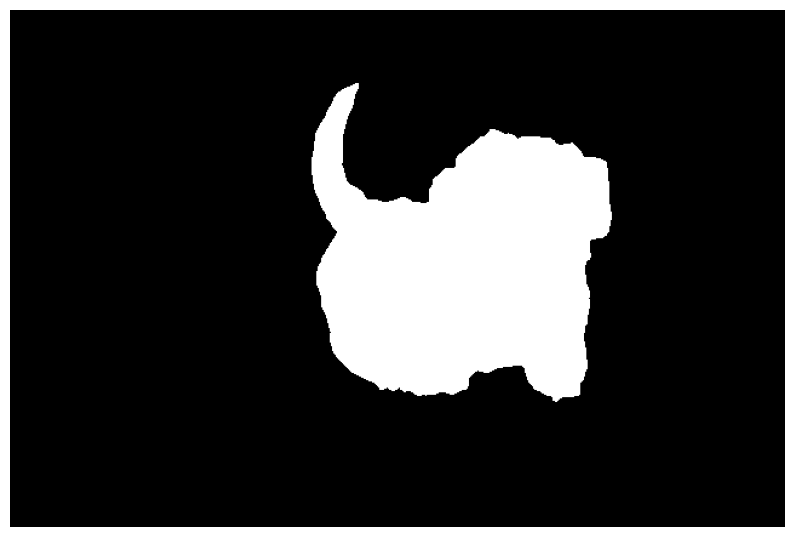

In [16]:
# Cell 4: Load the modified image and mask

# Load the modified image (where object is blacked out)
image_rgb = cv2.imread("modified_image.jpg")  # Assuming the image is saved in this path
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for PIL

# Use the mask you generated from SAM
mask = masks[0]  # The first mask or any mask you generated

# Convert the mask to binary (0 or 255)
binary_mask = (mask * 255).astype(np.uint8)

# Convert the modified image and mask to PIL format for Stable Diffusion
image_pil = Image.fromarray(image_rgb)
mask_pil = Image.fromarray(binary_mask)

# Display the mask to verify
plt.figure(figsize=(10, 10))
plt.imshow(binary_mask, cmap="gray")
plt.axis('off')
plt.show()

In [ ]:
# Cell 6: Perform inpainting using Stable Diffusion
# Run the inpainting pipeline
result = pipe(
    prompt="a natural background",  # You can change this prompt as needed
    image=image_pil,
    mask_image=mask_pil
)

# Get the generated inpainted image
inpainted_image = result.images[0]

# Convert the result back to OpenCV format
inpainted_image_cv2 = pil_to_cv2(inpainted_image)

# Display the result (optional)
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(inpainted_image_cv2, cv2.COLOR_BGR2RGB))
plt.show()

# Cell 7: Save the inpainted image
cv2.imwrite("inpainted_image.jpg", inpainted_image_cv2)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# import torch
# from diffusers import StableDiffusionInpaintPipeline
# from PIL import Image
# import numpy as np
# import cv2

# # Load the Stable Diffusion inpainting pipeline
# pipe = StableDiffusionInpaintPipeline.from_pretrained(
#     "runwayml/stable-diffusion-inpainting",
#     torch_dtype=torch.float16
# ).to("cuda")

# # Convert OpenCV images (BGR) to PIL format
# def cv2_to_pil(img):
#     return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# # Convert PIL image to OpenCV (BGR format)
# def pil_to_cv2(pil_img):
#     return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

# # Load your image with blacked-out area and mask
# image_with_black = cv2.imread("/content/modified_image.jpg")  # Image with object removed

# # Convert images to PIL format as required by Stable Diffusion
# image_pil = cv2_to_pil(image_with_black)
# mask_pil = Image.fromarray(mask)

# # Perform inpainting using Stable Diffusion
# prompt = "Fill in this area with natural scenery"  # Modify the prompt based on your image context
# inpainted_image = pipe(prompt=prompt, image=image_pil, mask_image=mask_pil).images[0]

# # Convert the inpainted image back to OpenCV format if needed
# inpainted_image_cv2 = pil_to_cv2(inpainted_image)

# # Save or display the result
# cv2.imwrite("inpainted_image.jpg", inpainted_image_cv2)
# cv2.imshow("Inpainted Image", inpainted_image_cv2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# img = cv2.imread("/content/stool.jpeg")
# weights = "/content/yolov3.weights"
# config = "/content/yolov3.cfg"
# cv.detect_common_objects(img)
# bbox, label, conf = cv.detect_common_objects(img)
# output_image = draw_bbox(img, bbox, label, conf)
# cv2.imwrite("output.jpg", output_image)

In [ ]:
# from ultralytics import YOLO
# import cv2
# from segment_anything import sam_model_registry, SamPredictor
# from PIL import Image as Img
# import numpy as np

# # Load YOLOv8 model
# model = YOLO('yolov8n.pt')

# # Load SAM model
# sam_checkpoint = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"
# model_type = "vit_h"
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# def detect_and_segment_stool(image_path):
#   # Object detection with YOLO
#   results = model(image_path)

#   # Check if any objects are detected
#   if results[0].boxes.xyxy is not None:
#     # Get bounding box for chairs (potential stools)
#     for r in results:
#       for box in r.boxes:
#         if model.names[int(box.cls)] == 'chair':
#           x1, y1, x2, y2 = box.xyxy[0].tolist()
#           bbox = np.array([x1, y1, x2, y2])

#           # Load image and convert to RGB
#           image = cv2.imread(image_path)
#           image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#           # SAM refinement
#           predictor = SamPredictor(sam)
#           predictor.set_image(image_rgb)
#           masks, _, _ = predictor.predict(
#               point_coords=None,
#               point_labels=None,
#               box=bbox,
#               multimask_output=False,
#           )
#           mask = masks[0].astype(np.uint8)

#           # Overlay mask on image
#           overlaid_image = overlay_mask(image, mask)
#           return overlaid_image
#   else:
#     # Return original image if no chairs are detected
#     return cv2.imread(image_path)

# def overlay_mask(image, mask):
#     if image is None:
#         raise ValueError("Image not found or unable to load.")

#     if len(mask.shape) == 3 and mask.shape[-1] == 3:
#         mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

#     _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     overlaid_image = image.copy()
#     cv2.drawContours(overlaid_image, contours, -1, (0, 0, 255), 2)
#     return overlaid_image

# # Example usage
# image_path = "/content/stool.jpeg"
# result_image = detect_and_segment_stool(image_path)
# Img.fromarray(result_image)


image 1/1 /content/stool.jpeg: 640x608 3 potted plants, 2 vases, 45.7ms
Speed: 2.6ms preprocess, 45.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [ ]:
# import cv2
# import numpy as np
# from segment_anything import sam_model_registry, SamPredictor
# from PIL import Image

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# sam = sam_model_registry["vit_h"](checkpoint="/content/drive/MyDrive/sam_vit_h_4b8939.pth")

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
# def segment_object(image_path, point_prompt):
#   # Load the image
#   image = cv2.imread(image_path)

#   # Ensure the image is in the correct format (RGB)
#   image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#   predictor = SamPredictor(sam)

#   # Set the image for the predictor
#   predictor.set_image(image_rgb)

#   point_label = np.array([1])  # Label for the point (1 means foreground)

#   # Predict the mask for the object using the prompt
#   masks, _, _ = predictor.predict(point_prompt, point_label)

#   # Convert the mask to the required format (2D binary mask)
#   mask = masks[0].astype(np.uint8)  # The first mask is typically the most relevant

#   return mask


In [ ]:
# def overlay_mask(image, mask):
#     # Check if the image is loaded correctly
#     if image is None:
#         raise ValueError("Image not found or unable to load.")

#     # Check if the mask is 3-channel and convert it to 2D grayscale if necessary
#     if len(mask.shape) == 3 and mask.shape[-1] == 3:
#         mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

#     # Ensure the mask is binary (0 or 255) by thresholding
#     _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

#     # Find contours of the mask
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Create a red overlay on the original image
#     overlaid_image = image.copy()
#     cv2.drawContours(overlaid_image, contours, -1, (0, 0, 255), 2)

#     return overlaid_image

In [ ]:
# def change_position(image, mask, x_shift, y_shift):
#     # Check if the image is loaded correctly
#     if image is None:
#         raise ValueError("Image not found or unable to load.")

#     # Ensure the mask is binary (0 or 255) by thresholding
#     _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

#     # Get the bounding rectangle of the mask
#     x, y, w, h = cv2.boundingRect(mask)

#     # Calculate the new position of the object
#     new_x = max(0, x + x_shift)
#     new_y = max(0, y + y_shift)

#     # Ensure the object stays within the image boundaries
#     new_x = min(new_x, image.shape[1] - w)
#     new_y = min(new_y, image.shape[0] - h)

#     # Create a blank image for the shifted object
#     shifted_image = np.zeros_like(image)

#     # Extract the object from the original image using the mask
#     object_image = cv2.bitwise_and(image, image, mask=mask)

#     # Copy the object to the new position in the shifted image
#     shifted_image[new_y:new_y+h, new_x:new_x+w] = object_image[y:y+h, x:x+w]

#     # Create a copy of the original image
#     result_image = image.copy()

#     # Remove the original object from the copied image
#     result_image[mask > 0] = 0

#     # Combine the shifted object with the modified original image
#     result_image = cv2.add(result_image, shifted_image)

#     return result_image

In [ ]:
# from google.colab import files
# uploaded = files.upload()  # Upload image files

Saving stool.jpeg to stool.jpeg


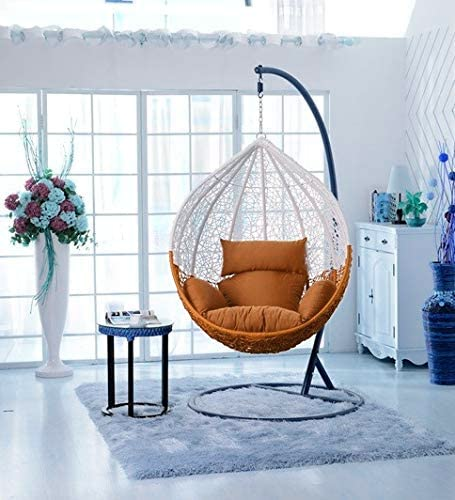

In [ ]:
# image_path = "/content/stool.jpeg"  # Replace with your image path
# point_prompt = np.array([[250, 250]])  # Example point prompt, replace with actual coordinates of the object
# mask = segment_object(image_path, point_prompt) # Call segment_object with point_prompt
# overlaid_image = overlay_mask(cv2.imread(image_path), mask)

# Image.fromarray(overlaid_image)


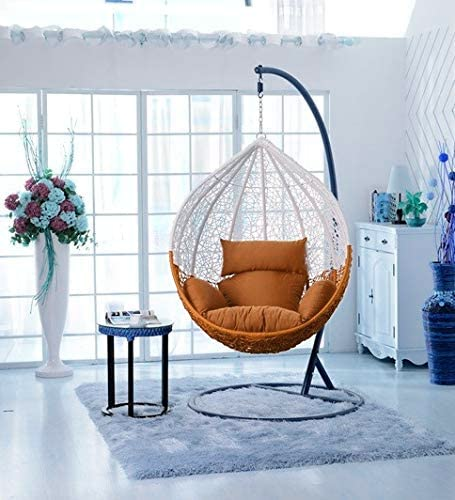

In [ ]:
# x_shift = 80  # Horizontal shift
# y_shift = 0   # Vertical shift
# new_image = change_position(cv2.imread(image_path), mask, x_shift, y_shift)

# # Display the new image with the shifted object
# Image.fromarray(new_image)